# Ex8

## Load and import

In [1]:
import torch
import MNIST_dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch import nn, optim
from typing import Dict, Optional, Tuple, List
import sys

# %% set torches random seed
torch.random.manual_seed(0)

# File manager
PATH = os.getcwd()
data_loc = os.path.join(PATH,'data')
# make fodler for exercise 7 and 8
data_loc_ex8 = os.path.join(data_loc,'ex8')
data_loc_ex78 = os.path.join(data_loc,'ex78')
loc = '/Users/lynch_mini/Library/CloudStorage/OneDrive-TUEindhoven/Q4_5LSL0 Machine learning for signal processing/Assignment3/Code - for students'
local_one = os.path.join(os.path.dirname(''), loc)
# os.mkdir(data_loc_ex78) 
# print(data_loc_ex78)
fig_loc = os.path.join(data_loc,'Fig')

data_loc_MNSIST = os.path.join(data_loc,os.path.abspath("."),"MNIST")
# print(data_loc_MNSIST)

batch_size = 64
# device fridenly not at all
if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc_MNSIST, batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

/Users/lynch_mini/Documents/SML/5LSL0_HW/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A

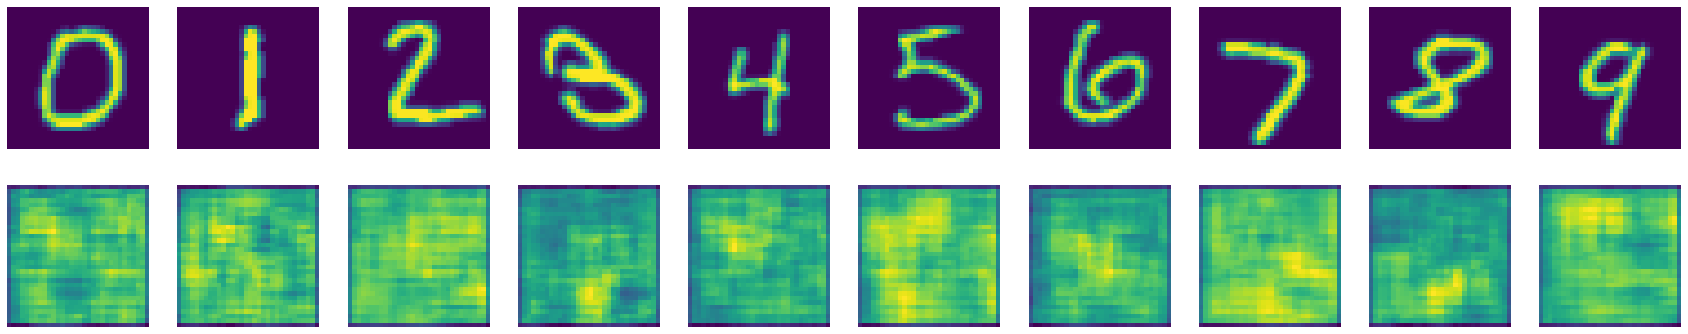

In [8]:
from matplotlib import pyplot as plt
from torchvision.transforms import functional as TF
def plot(ax,clean_image,output_image,labels,n_ros=2,n_cols=10):
    for i in range(n_cols):
        label=labels[i]
        ax[0][i].imshow(clean_image[i])
        ax[1][i].imshow(output_image[i])
        # ax[0][i].set_title(f"clean{label}")
        # ax[1][i].set_title(f"generated{label}")
        ax[0][i].axis("off")
        ax[1][i].axis("off")


model_VAE = VAE(1).to(device)

mu,sigma,fc1,output = model_VAE(x_clean_example.to(device))
fig=plt.figure(figsize=(10*3,2*3))
ax=fig.subplots(2,10)
plot(ax,x_clean_example.permute(0,2,3,1).numpy().squeeze(),output.cpu().detach().permute(0,2,3,1).numpy().squeeze(),labels_example,2,10)

In [3]:

# learning_rate = 3e-4
# no_epochs = 50
# optimizer_VAE = optim.Adam(model_VAE.parameters(),lr = learning_rate)
# loss_iter = []
# loss_epoch = []
# loss_iter_test = []
# loss_epoch_test = []
# torch.random.manual_seed(0)

## A) 
Implemented the equation 4.

$$
\begin{equation*}
    argmin ||x_{noisy}-g(z_{estimate}) ||^2_2+\beta||z_{estimate||^2_2
\end{equation*}
$$
### Ex8 model

In [2]:
# %% imports
# Ex8
import torch
import torch.nn as nn
# Build an Encoder for classfication
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self,in_channel=1):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channel, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to
            nn.Flatten() 
        )
        self.Emu = nn.Linear(2*2*16,16) # org 2 vec, to 16 channels
        self.E_logVar= nn.Linear(2*2*16,16) # org 2 vec, to 16 channels
        self.N = torch.distributions.Normal(0,1) # normal dis sample
        self.KL = 0 # not KL divergence yet
        
    def forward(self, x):
        # use the created layers here
        x =  self.encoder(x)
        mu = self.Emu(x)
        LogVar = self.E_logVar(x)
        Std = torch.exp(LogVar/2)
        LaVar = mu+Std*self.N.sample(mu.shape).to(device)
        # calculate KL
        self.KL = (Std**2 + mu**2 - torch.log(Std)-0.5).sum()
        return mu, Std, LaVar
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self,out_channel=1):
        super(Decoder, self).__init__()
        self.DE = nn.Sequential(
            nn.Linear(16,16*4*4),
            nn.ReLU(inplace=True)
        )
        # create layers here
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),                     # Upsampling to 2x2x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),                     # Upsampling to 4x4x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),                     # Upsampling to 8x8x16

            nn.ConvTranspose2d(16,out_channel,3, padding=1), 
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 16x16x16
            # nn.ConvTranspose2d(in_channels = 16 , out_channels = 1, kernel_size=3, padding=1), 
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 32x32x1
        )
        # self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, h):
        DE = self.DE(h)
        DE = DE.reshape(-1,16,4,4)
        r = self.Decoder(DE)
        # return self.Decoder(h) 
        return DE,r

# %%  Autoencoder
class VAE(nn.Module):
    def __init__(self,channel=1):
        super(VAE, self).__init__()
        self.encoder = Encoder(channel)
        self.decoder = Decoder(channel)
        
    def forward(self, x):
        mu,Std,LaVar = self.encoder(x)
        DE,r = self.decoder(LaVar)
        return mu,Std,DE,r
    


In [3]:
# Sanity check
sanity_check = torch.ones((64,1,32,32)).to(device)
encoder_check = Encoder(1)
mu,sigma,z = encoder_check.forward(sanity_check)
print(f"Encoder check:{mu.shape},{sigma.shape},{z.shape}")
decoder_check = Decoder(1)
fc1,r = decoder_check.forward(z)
print(f"Decoder check:{fc1.shape},{r.shape}")
VAE_check = VAE(1)
mu, log_std,fc1,r = VAE_check.forward(sanity_check)
print(f"VAE check:{r.shape}")
latent_check = torch.ones((64,16)).to(device)
fc1,output_check = VAE_check.decoder(latent_check)
print(f"VAE.decoder check:{output_check.shape}")

Encoder check:torch.Size([64, 16]),torch.Size([64, 16]),torch.Size([64, 16])
Decoder check:torch.Size([64, 16, 4, 4]),torch.Size([64, 1, 32, 32])
VAE check:torch.Size([64, 1, 32, 32])
VAE.decoder check:torch.Size([64, 1, 32, 32])


## Train new model save on onedrive

In [8]:
import torch.nn.functional as F
# Train the new variatonal autoencoder

model_VAE = VAE(1).to(device)
learning_rate = 1e-4
no_epochs = 50
optimizer_VAE = optim.Adam(model_VAE.parameters(),lr = learning_rate)
loss_iter = []
loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)

for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    # sys.stdout.flush()
    total_loss=0
    model_VAE.train()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        optimizer_VAE.zero_grad()
        inputs = x_clean.to(device=device)

        mu,sigma,fc1,outputs= model_VAE(inputs)
        # recst_loss = F.mse_loss(outputs,inputs)
        # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
        loss = F.mse_loss(outputs,inputs,reduction='sum') + 10*model_VAE.encoder.KL
        # loss = torch.sum((outputs-inputs)**2)+kl_div
        loss.backward()
        optimizer_VAE.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    # print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Train):{total_loss/len(train_loader)}')
    # sys.stdout.flush()
    total_loss = 0
    model_VAE.eval()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(test_loader)):
        inputs = x_clean.to(device=device)
        mu,sigma,fc1,outputs= model_VAE(inputs)
        # recst_loss = F.mse_loss(outputs,inputs)
        # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
        # loss_test = recst_loss + kl_div
        loss_test = F.mse_loss(outputs,inputs,reduction='sum') + 10*model_VAE.encoder.KL
        loss_iter_test.append(loss_test.data)
        total_loss += loss_test.data
    loss_epoch_test.append(total_loss/len(test_loader))
    # print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Test):{total_loss/len(test_loader)}')





# print(local_one)

torch.save(model_VAE,os.path.join(local_one,'exercise_VAE.ptg'))
# torch.save(model_VAE,os.path.join(data_loc_ex8,'exercise_Ex8_epo1_VAE.ptg'))

Training on cpu. Epoch 1:


100%|██████████| 157/157 [00:08<00:00, 18.61it/s]


Training on cpu. Epoch 2:


100%|██████████| 157/157 [00:06<00:00, 22.96it/s]


## plot rain loss of new model


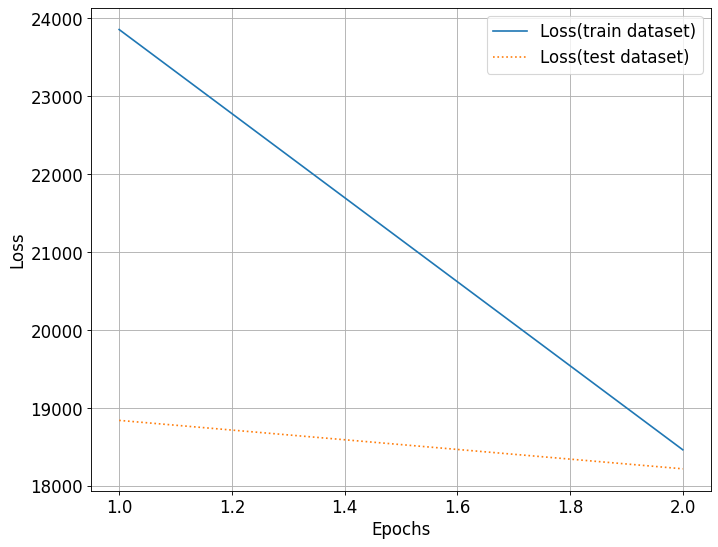

In [9]:
# plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# # plt.subplot(1,2,1)
# plt.plot(range(1,no_epochs+1),loss_epoch,label='Loss(train dataset)',linestyle='-')
# plt.plot(range(1,no_epochs+1),loss_epoch_test,label='Loss(test dataset)',linestyle=':')
# plt.legend(loc=1,prop={'size': 15})
# plt.xlabel("Epochs",fontdict={'size':15})
# plt.ylabel("Loss",fontdict={'size':15})

# plt.xticks(size=15)
# plt.yticks(size=15)
# plt.grid()
# plt.savefig(os.path.join(local_one,"Ex8_loss.png"),dpi=80,bbox_inches='tight')
# plt.show()

## repaint ex7

In [15]:
data_loc_ex78 = os.path.join(data_loc,'ex78')
model_VAE = torch.load(os.path.join(data_loc_ex78,"exercise_VAE_50_new.ptg"))
with torch.no_grad():
    _,outputs_noisy = model_VAE.decoder(x_noisy_example)

plt.figure(figsize=(30,10))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+11)
    plt.imshow(outputs_noisy[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+21)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
# fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(fig_path,"exercise_new_VAE_8b_examples.png"),dpi=80,bbox_inches='tight')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (320x32 and 2x16)

### MAP - Estimate laten space

100%|██████████| 1000/1000 [00:05<00:00, 174.39it/s]


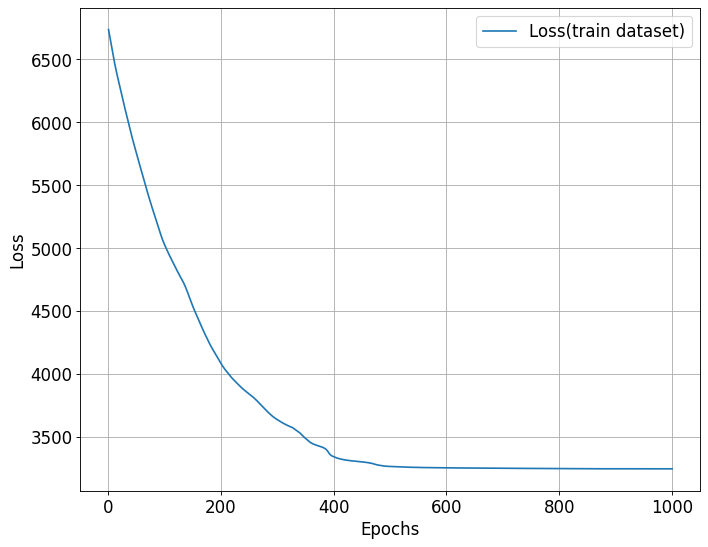

In [7]:
## implement eqn 4.
# data_loc_ex8 = os.path.join(data_loc,'ex8')
# torch.save(model_VAE,os.path.join(local_one,'exercise_VAE.ptg'))
model_VAE = torch.load(os.path.join(local_one,"exercise_VAE_ex8_50.ptg"),map_location='cpu')
# model_VAE = VAE(1).to(device)
# model_VAE = torch.load(os.path.join(local_one,"exercise_VAE.ptg"))

# model_VAE = VAE(1).to(device=device)
no_iterations = 1000
learning_rate = 1e-2
beta = 0.65
estimated_latent = nn.Parameter(torch.randn(10,16))
# optimizer_map = torch.optim.Adam([estimated_latent],lr = learning_rate)
optimizer_map = torch.optim.Adam([estimated_latent],lr = learning_rate)
no_epochs = no_iterations
loss_iter = []
loss = 0

loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)

for i in tqdm(range(no_iterations)):
    optimizer_map.zero_grad()
    _,z_estimate = model_VAE.decoder(estimated_latent)
    # print(x_noisy_example.shape)
    # print(z_estimate.shape)
    loss = ((x_noisy_example-z_estimate)**2).sum() + beta * ((estimated_latent**2).sum())
    loss.backward()
    optimizer_map.step()
    loss_iter.append(loss.item())

plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
plt.plot(range(1,no_epochs+1),loss_iter,label='Loss(train dataset)',linestyle='-')
# plt.plot(range(1,no_epochs+1),loss_epoch_test,label='Loss(test dataset)',linestyle=':')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("Loss",fontdict={'size':15})

plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
# plt.savefig(os.path.join(local_one,"Ex8_loss.png"),dpi=80,bbox_inches='tight')
plt.show()

torch.Size([10, 16])
torch.Size([10, 1, 32, 32])


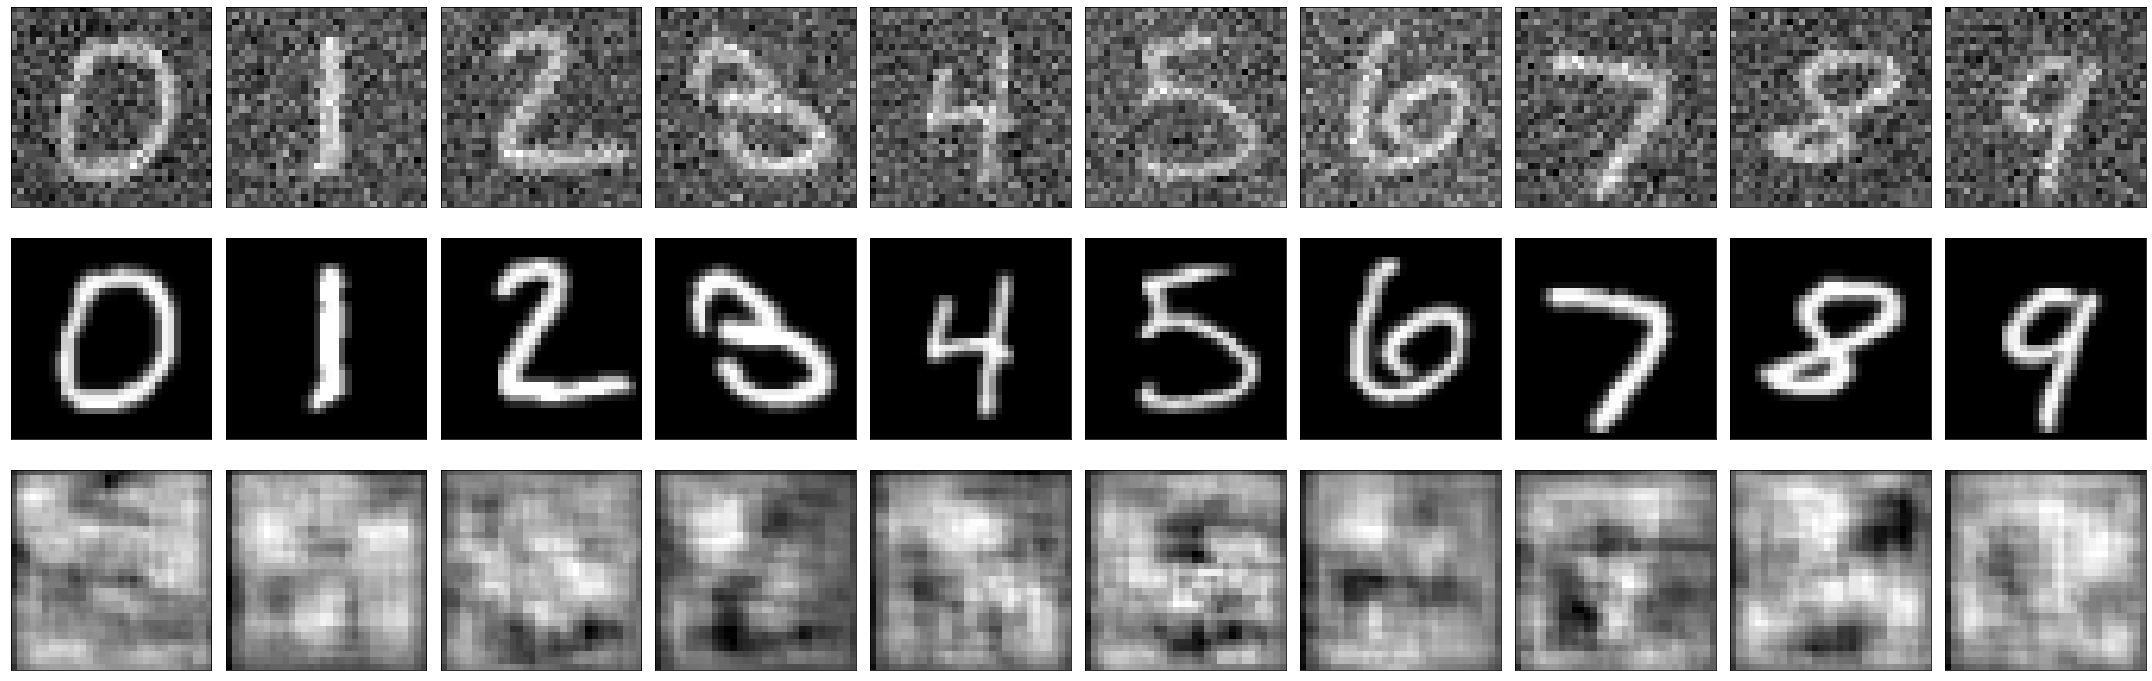

In [13]:
model_VAE = VAE(1).to(device)
print(estimated_latent.shape)
print(x_noisy_example.shape)
with torch.no_grad():
    _,outputs_noisy = model_VAE.decoder(estimated_latent) # estimated_latent

plt.figure(figsize=(30,10))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,10,i+11)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,10,i+21)
    plt.imshow(outputs_noisy[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    
    
    
    

plt.tight_layout()
# fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(local_one,"exercise_new_VAE_8_MAP.png"),dpi=80,bbox_inches='tight')
plt.show()

## Latenet space Ex8


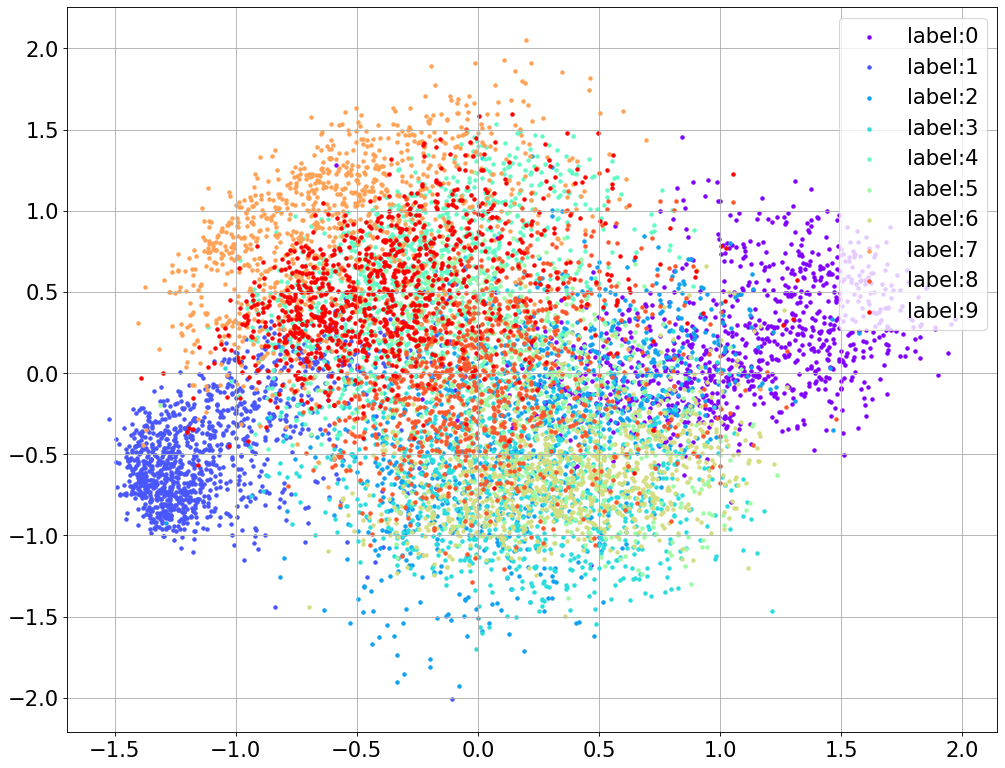

In [22]:
model_VAE.eval()
with torch.no_grad():
    mu,log_var,fc1,outputs = model_VAE(x_clean_test.to(device))

import matplotlib.cm as cm
import numpy as np

colors = cm.rainbow(np.linspace(0, 1,10))
plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    c = colors[i]
    latent_c = mu[torch.where(labels_test==i)]
    # if i == 3 or i==6:
    plt.scatter(latent_c[:,0].cpu(), latent_c[:,1].cpu(), color=c,label=f"label:{i}",marker='.')

plt.xticks(size=19)
plt.yticks(size=19)
plt.legend(loc=1,prop={'size': 19})
plt.grid()
# plt.savefig(os.path.join(fig_path,"Exercise_VAE_scatter.png"),dpi=80,bbox_inches='tight')
plt.show()

In [16]:
x = torch.arange(-2,1,3/15)
y = torch.arange(-1.5,1.5,3/15)
latent_VAE = torch.zeros((16*16,16),requires_grad=False) # 15*15 ,2
for i in range(15):
    for j in range(15):
        latent_VAE[i*15+j,:] = torch.Tensor([x[i],y[j]])

with torch.no_grad():
    _,output_VAE = model_VAE.decoder(latent_VAE.to(device))


plt.figure(figsize=(15,15))
for i in range(15):
    for j in range(15):
        plt.subplot(15,15,i*15+j+1)
        plt.imshow(output_VAE[(14-i)*15+j,0,:,:].cpu(),cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.subplots_adjust(wspace=0,hspace=0)
fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(fig_path,"exercise5_VAE.png"),dpi=80,bbox_inches='tight')
plt.show()

RuntimeError: The expanded size of the tensor (16) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [16].  Tensor sizes: [2]

In [13]:
# # Train the new variatonal autoencoder
# data_loc_ex8 = os.path.join(data_loc,'ex8')
# model_VAE = torch.load(os.path.join(data_loc_ex8,"exercise_Ex8_epo1_VAE.ptg"))

# with torch.no_grad():
#     _,_,_,outputs_noisy = model_VAE(x_noisy_example)
# # _,_,_,outputs_noisy = model_VAE.encoder(x_noisy_example)

# # model_VAE = VAE(1).to(device)
# learning_rate = 1e-4
# no_epochs = 2
# # optimizer_VAE = optim.Adam(model_VAE.parameters(),lr = learning_rate)
# loss_iter = []
# loss_epoch = []
# loss_iter_test = []
# loss_epoch_test = []
# torch.random.manual_seed(0)

In [14]:
# import torch.nn.functional as F

# for epoch in range(no_epochs):
#     print(f"Training on {device}. Epoch {epoch+1}:")
#     # go over all minibatches
#     # sys.stdout.flush()
#     total_loss=0
#     model_VAE.train()
#     for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
#         # fill in how to train your network using only the clean images
#         optimizer_map.zero_grad()
#         inputs = x_clean.to(device=device)

#         mu,sigma,fc1,outputs= model_VAE(inputs)
#         # recst_loss = F.mse_loss(outputs,inputs)
#         # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
#         loss = F.mse_loss(outputs,inputs,reduction='sum') + 10*model_VAE.encoder.KL
#         # loss = torch.sum((outputs-inputs)**2)+kl_div
#         loss.backward()
#         optimizer_map.step()
#         loss_iter.append(loss.data)
#         total_loss += loss.data
#     loss_epoch.append(total_loss/len(train_loader))
#     # print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Train):{total_loss/len(train_loader)}')
#     # sys.stdout.flush()
#     total_loss = 0
#     model_VAE.eval()
#     for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(test_loader)):
#         inputs = x_clean.to(device=device)
#         mu,sigma,fc1,outputs= model_VAE(inputs)
#         # recst_loss = F.mse_loss(outputs,inputs)
#         # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
#         # loss_test = recst_loss + kl_div
#         loss_test = F.mse_loss(outputs,inputs,reduction='sum') + 10*model_VAE.encoder.KL
#         loss_iter_test.append(loss_test.data)
#         total_loss += loss_test.data
#     loss_epoch_test.append(total_loss/len(test_loader))
#     # print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Test):{total_loss/len(test_loader)}')


# # torch.save(model_VAE,os.path.join(data_loc_ex8,'exercise_Ex8_epo1_VAE.ptg'))

In [15]:
# # reconstruction examples
# with torch.no_grad():
#     _,outputs_noisy = model_VAE.decoder(x_noisy_example)

# plt.figure(figsize=(30,10))
# for i in range(10):
#     plt.subplot(3,10,i+1)
#     plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(3,10,i+11)
#     plt.imshow(outputs_noisy[i,0,:,:],cmap='gray')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(3,10,i+21)
#     plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
#     plt.xticks([])
#     plt.yticks([])

# plt.tight_layout()
# fig_path = os.path.join(os.path.abspath("."),"figure")
# # plt.savefig(os.path.join(fig_path,"exercise_new_VAE_8b_examples.png"),dpi=80,bbox_inches='tight')
# plt.show()

## Ex8 MAP 
With laten variable

In [16]:
# model_VAE = torch.load(os.path.join(data_loc_ex8,"exercise_Ex8_VAE.ptg"))
no_iterations = 1000
learning_rate = 1e-2
beta = 0.01
estimated_latent = nn.Parameter(torch.randn(10,16))
# optimizer_map = torch.optim.Adam([estimated_latent],lr = learning_rate)
optimizer_map = torch.optim.Adam([estimated_latent],lr = learning_rate)
no_epochs = 30
loss_iter = []
loss = 0

loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)

for i in tqdm(range(no_iterations)):
    optimizer_map.zero_grad()
    _,z_estimate = model_VAE.decoder(estimated_latent)
    # print(x_noisy_example.shape)
    # print(z_estimate.shape)
    loss = ((x_noisy_example-z_estimate)**2).sum() + beta * ((estimated_latent**2).sum())
    loss.backward()
    optimizer_map.step()
    loss_iter.append(loss.item())

100%|██████████| 1000/1000 [00:08<00:00, 112.45it/s]


### plot Laten variable

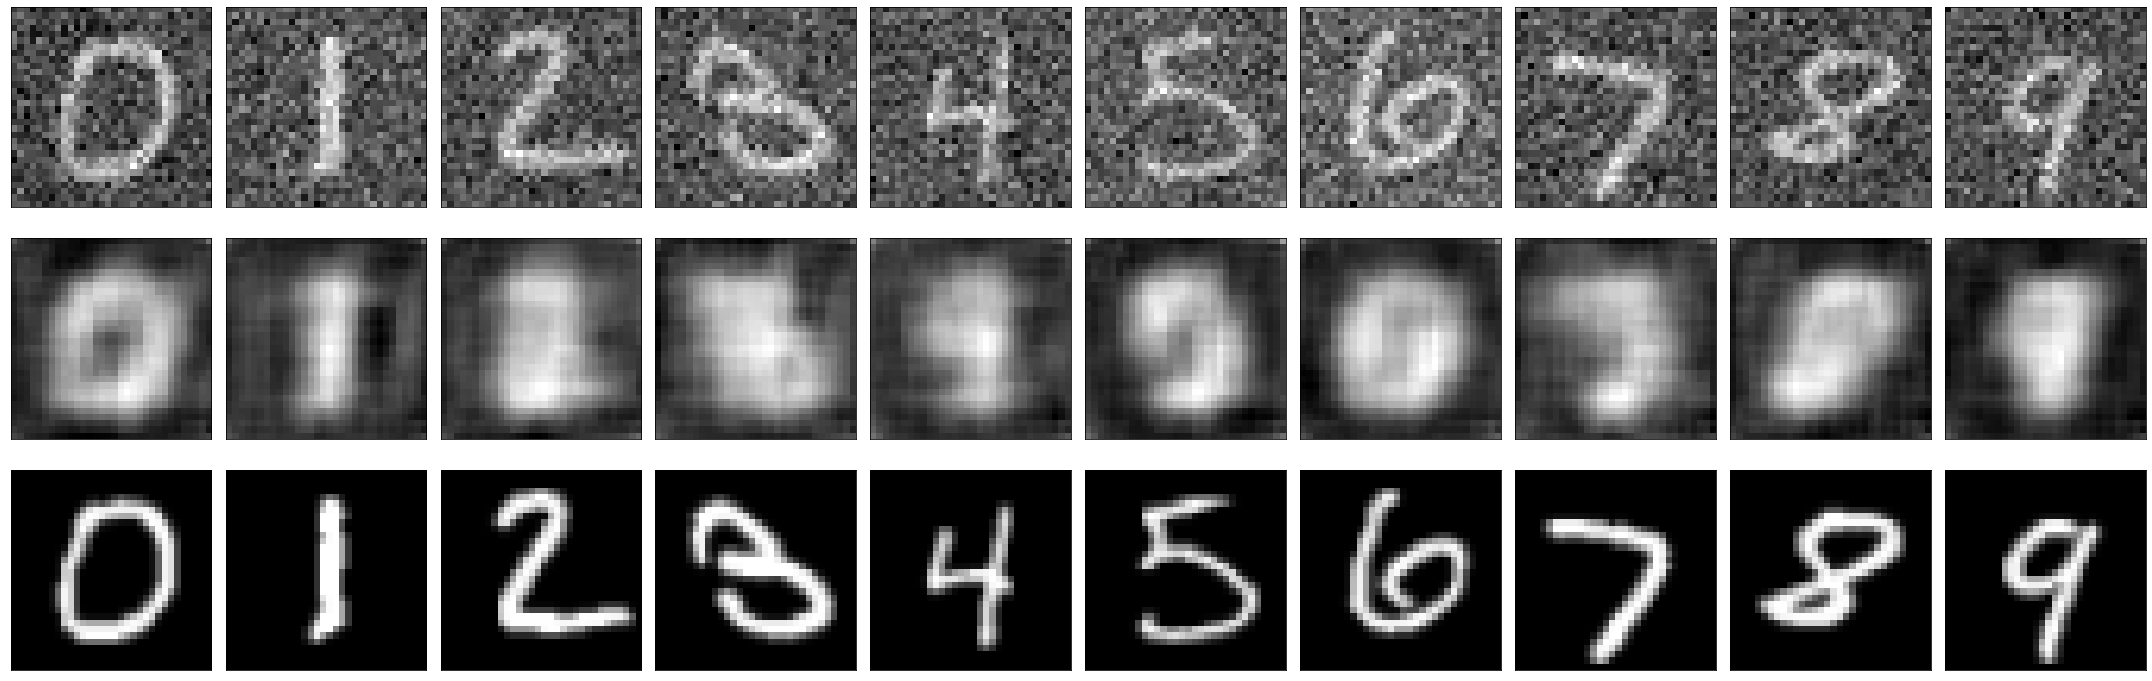

In [17]:
# reconstruction examples
with torch.no_grad():
    _,outputs_noisy = model_VAE.decoder(estimated_latent)

plt.figure(figsize=(30,10))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+11)
    plt.imshow(outputs_noisy[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+21)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(fig_path,"exercise_new_VAE_8b_examples.png"),dpi=80,bbox_inches='tight')
plt.show()

### Trainloss

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

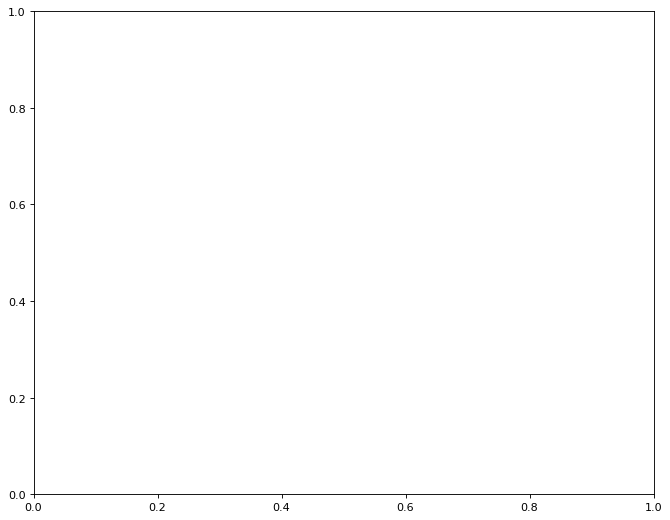

In [18]:
plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
plt.plot(range(1,no_epochs+1),loss_epoch,label='Loss(train dataset)',linestyle='-')
plt.plot(range(1,no_epochs+1),loss_epoch_test,label='Loss(test dataset)',linestyle=':')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("MAP Loss",fontdict={'size':15})

plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
# plt.savefig(os.path.join(fig_loc,"Ex8_loss.png"),dpi=80,bbox_inches='tight')
plt.show()

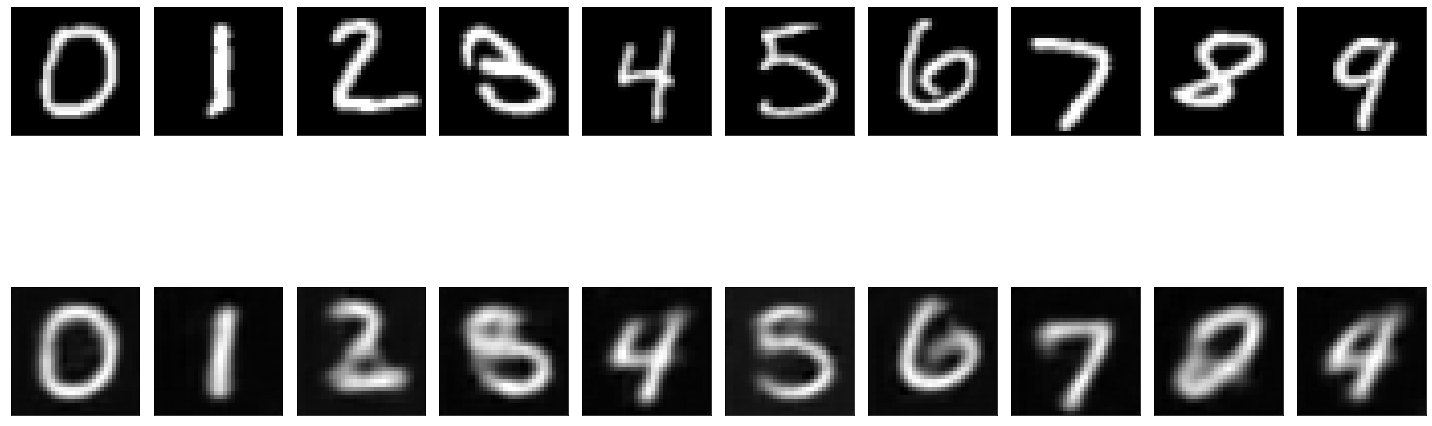

In [ ]:
# model_VAE = torch.load(os.path.join(model_loc,"exercise_VAE.ptg"))

examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
with torch.no_grad():
    mu,log_var,fc1,output_VAE = model_VAE(x_clean_example.to(device))

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,10,i+11)
    plt.imshow(output_VAE[i,0,:,:].cpu(),cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(fig_loc,"Ex8_VAE_3r.png"),dpi=80,bbox_inches='tight')
plt.show()

### Ex8 Laten space

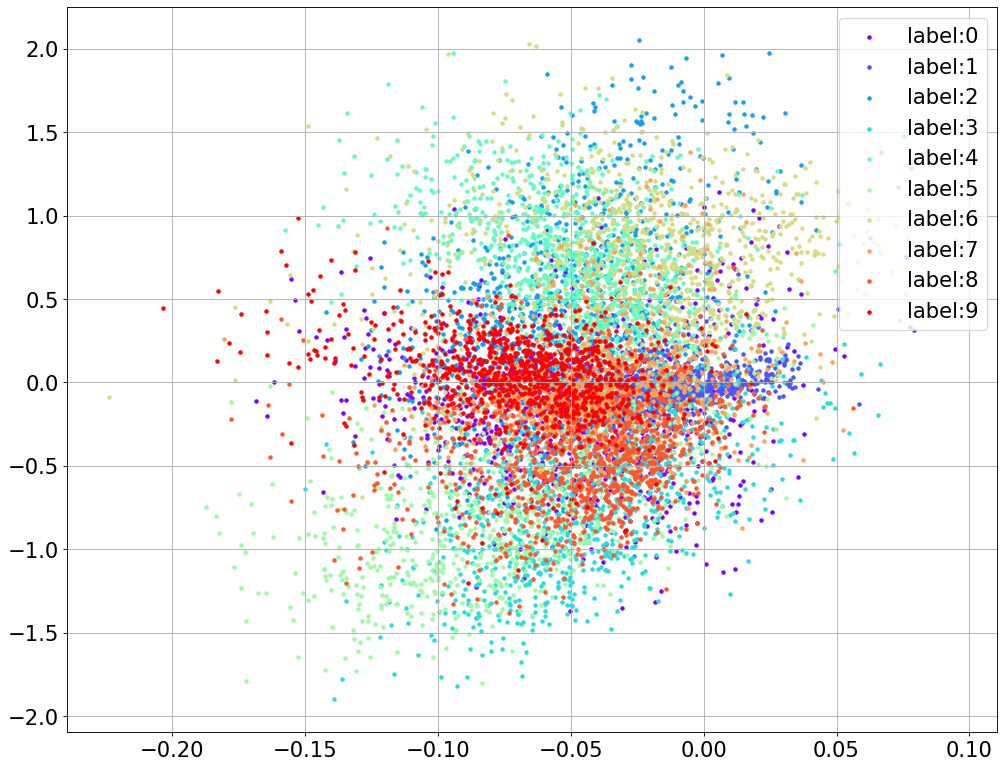

In [ ]:
model_VAE.eval()
with torch.no_grad():
    mu,log_var,fc1,outputs = model_VAE(x_clean_test.to(device))

import matplotlib.cm as cm
import numpy as np

colors = cm.rainbow(np.linspace(0, 1,10))
plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    c = colors[i]
    latent_c = mu[torch.where(labels_test==i)]
    # if i == 3 or i==6:
    plt.scatter(latent_c[:,0].cpu(), latent_c[:,1].cpu(), color=c,label=f"label:{i}",marker='.')

plt.xticks(size=19)
plt.yticks(size=19)
plt.legend(loc=1,prop={'size': 19})
plt.grid()
# plt.savefig(os.path.join(fig_loc,"Ex8_VAE_scatter.png"),dpi=80,bbox_inches='tight')
plt.show()

### Ex8 grid